In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


ticket feature x
cabin x
passengerid x

parch and sib get total count
Name feature to extract title
we may want to create new feature for age bands

women, child, upperclass more likely survived important 이에 해당하는 특성previliage 하나 더 만드는걸 검토

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [48]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin,Familysize,isAlone,AgeBand,FareBand,Deck,Privileged,GroupSize,FarePerPerson
0,NaN,3,NaN,22.0,1,0,7.2500,S,Mr,0,2,0,1,0,NaN,0,Small,3.62500
1,NaN,1,NaN,38.0,1,0,71.2833,C,Mrs,1,2,0,2,3,NaN,1,Small,35.64165
2,NaN,3,NaN,26.0,0,0,7.9250,S,Miss,0,1,1,1,1,NaN,0,Small,7.92500
3,NaN,1,NaN,35.0,1,0,53.1000,S,Mrs,1,2,0,2,3,NaN,1,Large,26.55000
4,NaN,3,NaN,35.0,0,0,8.0500,S,Mr,0,1,1,2,1,NaN,0,Small,8.05000


In [ ]:
test.head()

In [ ]:
train.shape

In [ ]:
train.info()

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            332 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           417 non-null    float64
 9   Cabin          91 non-null     object 
 10  Embarked       418 non-null    object 
 11  Familysize     418 non-null    int64  
 12  isAlone        418 non-null    int64  
 13  Has_Cabin      418 non-null    int64  
 14  Title          418 non-null    object 
 15  Deck           418 non-null    object 
 16  GroupSize      418 non-null    int64  
 17  GroupCategory  418 non-null    object 
 18  FarePerPer

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
print(test[test['Title'].isnull()]['Name'])

In [ ]:
test['Title'] = test['Title'].fillna('Rare')

## Deck (객실 구역: A~G)

In [18]:
# train에 Deck 변수 생성
train['Deck'] = train['Cabin'].astype(str).str[0]
train['Deck'] = train['Deck'].replace('n', 'Unknown')  # 'nan' → 'Unknown'
train['Deck'] = train['Deck'].fillna('Unknown')

# test에도 동일하게
test['Deck'] = test['Cabin'].astype(str).str[0]
test['Deck'] = test['Deck'].replace('n', 'Unknown')
test['Deck'] = test['Deck'].fillna('Unknown')

# LabelEncoding
from sklearn.preprocessing import LabelEncoder
le_deck = LabelEncoder()
train['Deck'] = le_deck.fit_transform(train['Deck'])
test['Deck'] = le_deck.transform(test['Deck'])


## Privileged 변수 생성

In [19]:
# 조건 조합: 여성 or 어린이 중 하나 이상 AND 1등석
train['Privileged'] = (
    ((train['Sex'] == 0) | (train['AgeBand'] == 0)) & (train['Pclass'] == 1)
).astype(int)

test['Privileged'] = (
    ((test['Sex'] == 0) | (test['AgeBand'] == 0)) & (test['Pclass'] == 1)
).astype(int)


In [ ]:
print(train['Privileged'].value_counts())
print(train[['Privileged', 'Survived']].groupby('Privileged').mean())


## GroupSize: 성씨 + 티켓 기반 그룹 크기


In [20]:
# 성 추출
train['Surname'] = train['Name'].apply(lambda x: x.split(',')[0])
test['Surname'] = test['Name'].apply(lambda x: x.split(',')[0])

# Group ID 생성
train['GroupId'] = train['Ticket'].astype(str) + "_" + train['Surname']
test['GroupId'] = test['Ticket'].astype(str) + "_" + test['Surname']

# GroupSize 계산
train['GroupSize'] = train.groupby('GroupId')['GroupId'].transform('count')
test['GroupSize'] = test.groupby('GroupId')['GroupId'].transform('count')

# 중간 변수 제거 (선택)
train.drop(['Surname', 'GroupId'], axis=1, inplace=True)
test.drop(['Surname', 'GroupId'], axis=1, inplace=True)


## FarePerPerson (요금 / 인원)

In [21]:
train['FarePerPerson'] = train['Fare'] / train['Familysize']
test['FarePerPerson'] = test['Fare'] / test['Familysize']


## Age 결측치 처리 이름의 호칭의 나이의 평균을 결측치에 채움

In [3]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
title_map = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
    'Lady': 'Rare', 'Countess': 'Rare', 'Jonkheer': 'Rare',
    'Capt': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Dona': 'Rare'  # ← 추가
}

train['Title'] = train['Title'].map(title_map)

In [4]:
for title in train['Title'].unique():
    mean_age = train.loc[train['Title'] == title, 'Age'].mean()
    train.loc[(train['Age'].isnull()) & (train['Title'] == title), 'Age'] = mean_age

In [5]:
# 먼저 Title 추출해서 test에 추가
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].map(title_map)  # train과 같은 title_map 사용

# Title별 평균 나이 계산 후 결측치 채움
for title in test['Title'].unique():
    mean_age = train.loc[train['Title'] == title, 'Age'].mean()  # train 기준 평균 사용
    test.loc[(test['Age'].isnull()) & (test['Title'] == title), 'Age'] = mean_age


In [6]:
# 2. train 기준 Title별 평균 나이 계산
title_age_map = train.groupby('Title')['Age'].mean()

# 3. test의 Age 결측치 채우기
for title in test['Title'].unique():
    if title in title_age_map:
        test.loc[(test['Age'].isnull()) & (test['Title'] == title), 'Age'] = title_age_map[title]
    else:
        test.loc[(test['Age'].isnull()) & (test['Title'] == title), 'Age'] = train['Age'].mean()  # 혹시 없는 타이틀 대비


## Cabin 유무만 판단하는 파생 변수

In [7]:
train['Has_Cabin'] = train['Cabin'].notnull().astype(int)

## Embarked: 최빈값으로 채우기

In [8]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

/tmp/ipykernel_35/1031565505.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)


### Fare 분포 확인 (히스토그램)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(train['Fare'], bins=50, kde=True)
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.show()


In [ ]:
import numpy as np

train['LogFare'] = np.log1p(train['Fare'])

plt.figure(figsize=(8, 5))
sns.histplot(train['LogFare'], bins=50, kde=True, color='orange')
plt.title('Log-Transformed Fare Distribution')
plt.xlabel('Log(Fare)')
plt.ylabel('Number of Passengers')
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Pclass', y='Fare', data=train)
plt.title('Fare Distribution by Pclass')
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sns.violinplot(x='Survived', y='Fare', data=train)
plt.title('Fare vs Survival')
plt.xlabel('Survived')
plt.ylabel('Fare')
plt.show()


## 동반 가족수 특성 생성

In [9]:
train['Familysize'] = train['SibSp'] + train['Parch']+1
test['Familysize'] = test['SibSp'] + test['Parch']+1

### 혼자인 사람 특성 생성
설명:
(train['FamilySize'] == 1) → True / False 시리즈
.astype(int) → True → 1, False → 0 으로 바꿔줌


In [10]:
train['isAlone'] = (train['Familysize'] == 1).astype(int)


### 범주형 변수 인코딩 (Sex, Embarked, Title 등)

In [11]:
from sklearn.preprocessing import LabelEncoder

# 1. Sex 인코더
le_sex = LabelEncoder()
train['Sex'] = le_sex.fit_transform(train['Sex'])
test['Sex'] = le_sex.transform(test['Sex'])

# 2. Embarked 인코더
le_embarked = LabelEncoder()
train['Embarked'] = le_embarked.fit_transform(train['Embarked'])
test['Embarked'] = le_embarked.transform(test['Embarked'])

# 3. Title 인코더
le_title = LabelEncoder()
train['Title'] = le_title.fit_transform(train['Title'])
test['Title'] = le_title.transform(test['Title'])


In [ ]:
print(train['Sex'].unique())  # ['male', 'female'] → 문자이면 인코딩 가능


### AgeBand 만들기

In [ ]:
print(train[['AgeBand', 'Survived']].groupby('AgeBand').mean())

In [ ]:
print(test['Age'].isnull().sum())
print(test['AgeBand'].isnull().sum())


In [ ]:
print(test['Age'].max())  # 80보다 클 가능성 있음
print(age_bins)           # bins의 오른쪽 경계 확인


In [ ]:
print(test[test['AgeBand'].isnull()][['Age', 'Name']])


In [12]:
# 1. 안전한 구간 정의 (직접 지정)
age_bins = [0.0, 16.336, 32.252, 48.168, 64.084, 100]

# 2. train에 다시 적용
train['AgeBand'] = pd.cut(train['Age'], bins=age_bins)
le = LabelEncoder()
train['AgeBand'] = le.fit_transform(train['AgeBand'])

# 3. test에도 동일하게 적용
test['AgeBand'] = pd.cut(test['Age'], bins=age_bins)
test['AgeBand'] = le.transform(test['AgeBand'])  # fit은 하지 마세요!


In [ ]:
print(test['AgeBand'].isnull().sum())  # → 0이어야 OK
print(test['AgeBand'].value_counts())  # 숫자 0~4 확인
print(train['AgeBand'].isnull().sum())  # → 0이어야 OK
print(train['AgeBand'].value_counts())  # 숫자 0~4 확인


In [ ]:
print(le.classes_)


In [ ]:
print(train[['Age', 'AgeBand']].head(10))


In [ ]:
print(train[['AgeBand', 'Survived']].groupby('AgeBand').mean())


### FareBand 만들기

In [13]:
test['Fare'] = test['Fare'].fillna(train['Fare'].median())


In [15]:
# 1. 구간을 직접 지정 (사분위 대신 범위 기반으로 처리)
fare_bins = [0, 7.91, 14.454, 31.0, 600.0]  # 600까지 안전하게 확장

# 2. train/test에 같은 구간 적용
train['FareBand'] = pd.cut(train['Fare'], bins=fare_bins, include_lowest=True)
test['FareBand'] = pd.cut(test['Fare'], bins=fare_bins, include_lowest=True)

# 3. LabelEncoder 적용 (fit은 train만)
from sklearn.preprocessing import LabelEncoder
le_fare = LabelEncoder()
train['FareBand'] = le_fare.fit_transform(train['FareBand'])
test['FareBand'] = le_fare.transform(test['FareBand'])


In [ ]:
print(train['FareBand'].isnull().sum())  # 0이어야 정상
print(test['FareBand'].isnull().sum())   # 0이어야 정상
print(train['FareBand'].unique())        # [0, 1, 2, 3]
print(test['FareBand'].unique())         # [0, 1, 2, 3]


In [ ]:
print(test['Fare'].isnull().sum())        # 요금 자체 결측치
print(test['FareBand'].isnull().sum())    # 구간화 이후 결측치


항목	해석
test['Fare'] 결측치 1개	→ 값 자체가 비어 있음 → pd.cut() 불가 → FareBand NaN 발생
test['FareBand'] 결측치 2개	→ 위 1개 + 추가 1개는 값은 있지만 bin 범위를 벗어난 경우

### test 결측 변수 생성

In [16]:
test['Familysize'] = test['SibSp'] + test['Parch'] + 1  # 혹시 없으면 생성
test['isAlone'] = (test['Familysize'] == 1).astype(int)


In [17]:
test['Has_Cabin'] = test['Cabin'].notnull().astype(int)


##  불필요한 열 제거

In [22]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)


# 모델 학습

In [23]:
train_x = train.drop(columns=['Survived'])
train_y = train['Survived']
test_x = test.copy()

In [24]:
test_x = test_x[train_x.columns]  # ← 이 한 줄이 핵심!

### 기본 모델 성능 체크 (RandomForest)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model, train_x, train_y, cv=5)
print("기본 모델 CV 평균 정확도:", scores.mean())


기본 모델 CV 평균 정확도: 0.8148076078086749


### 앙상블 모델 도입 (VotingClassifier)



In [26]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(max_iter=1000)
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model3 = GradientBoostingClassifier(n_estimators=100, random_state=42)

ensemble = VotingClassifier(estimators=[
    ('lr', model1), ('rf', model2), ('gb', model3)
], voting='soft')

scores = cross_val_score(ensemble, train_x, train_y, cv=5)
print("앙상블 CV 평균 정확도:", scores.mean())


앙상블 CV 평균 정확도: 0.8238089259933463


### GridSearchCV,KFold – 데이터를 나눠서 정확도 검증

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

# 1. 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

# 2. KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. GridSearchCV 실행
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,  # ✅ 여기가 핵심 수정
    cv=kf,
    scoring='accuracy',
    n_jobs=-1
)

# 4. 학습
grid.fit(train_x, train_y)

# 5. 결과 출력
print("최고 교차검증 정확도:", grid.best_score_)
print("최적 파라미터 조합:", grid.best_params_)


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 최적 하이퍼파라미터 적용
best_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=4,
    max_features='sqrt',
    random_state=42
)

# 학습
best_model.fit(train_x, train_y)

# 예측
test_x = test_x[train_x.columns]  # 열 순서 동일하게
predictions = best_model.predict(test_x)

# 제출 파일 생성
import pandas as pd
original_test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.DataFrame({
    'PassengerId': original_test['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission_rf_best.csv', index=False)


In [ ]:
print(list(train_x.columns))
print(list(test.columns))


### XGBoost 적용

In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

scores = cross_val_score(xgb_model, train_x, train_y, cv=5)
print("XGBoost CV 평균 정확도:", scores.mean())


XGBoost CV 평균 정확도: 0.8215742891218379


## RandomForest + GradientBoosting + LogisticRegression을 base 모델로,
LogisticRegression을 meta 모델로 묶는 스태킹 앙상블 구성

In [29]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
# Base learners
from xgboost import XGBClassifier

estimators = [
    ('xgb', XGBClassifier(n_estimators=100, max_depth=3, use_label_encoder=False, eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000))
]

# Meta learner
meta_model = LogisticRegression(max_iter=1000)

# StackingClassifier
stack_model = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5)
scores = cross_val_score(stack_model, train_x, train_y, cv=5)
print("StackingClassifier CV 평균 정확도:", scores.mean())


StackingClassifier CV 평균 정확도: 0.8327600276191074


In [ ]:
stack_model.fit(train_x, train_y)


In [ ]:
original_test = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.DataFrame({
    'PassengerId': original_test['PassengerId'],
    'Survived': predictions
})
submission.to_csv("submission_stacking1.csv", index=False)


### 스택킹

In [36]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42))
]
# 스택킹 모델 정의 (앞서 설명한 base_models, meta_model 활용)
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# 교차검증 실행
scores = cross_val_score(stack_model, train_x, train_y, cv=5, scoring='accuracy')

# 결과 출력
print("StackingClassifier CV 정확도:", scores.mean())
print("Fold별 정확도:", scores)


StackingClassifier CV 정확도: 0.8238026489234826
Fold별 정확도: [0.81564246 0.80337079 0.83707865 0.80337079 0.85955056]


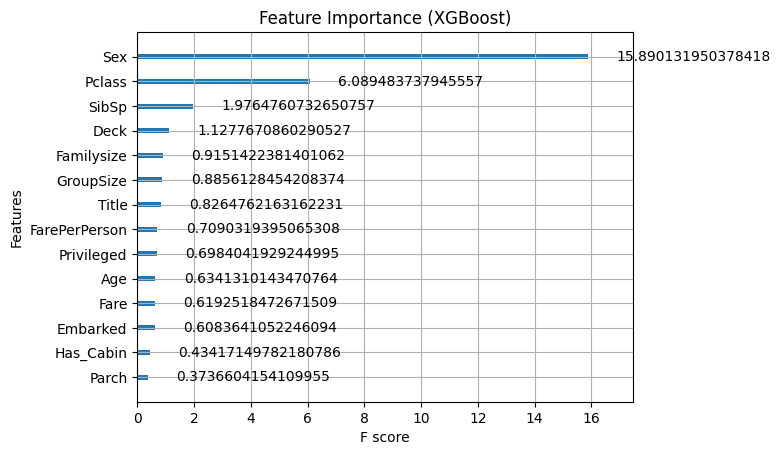

In [37]:
from xgboost import XGBClassifier, plot_importance

xgb_model = XGBClassifier(n_estimators=200, max_depth=4, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

# 기본 plot
plot_importance(xgb_model, importance_type='gain', max_num_features=15)
plt.title("Feature Importance (XGBoost)")
plt.show()


In [35]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 1. 기본 모델들 정의
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# 2. 최종 예측 모델
meta_model = LogisticRegression(max_iter=1000)

# 3. 스태킹 모델 정의
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False  # 필요 시 True로 바꿔보기도 가능
)

# 4. 학습
stack_model.fit(train_x, train_y)

# 5. 예측 (test_x는 train_x와 동일한 전처리 구조여야 함!)
test_x = test[train_x.columns]
predictions = stack_model.predict(test_x)
original_test = pd.read_csv("/kaggle/input/titanic/test.csv")
# 6. 제출
submission = pd.DataFrame({
    'PassengerId': original_test['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission_stacking.csv', index=False)


###  Base learner 다양화

In [34]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 1. base 모델 정의
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)),
    ('svc', SVC(probability=True)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# 2. meta 모델 정의
meta_model = LogisticRegression(max_iter=1000)

# 3. stacking classifier 정의
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# 4. 학습
stack_model.fit(train_x, train_y)

# 5. 예측 (test_x는 train_x와 동일한 전처리 구조여야 함!)
test_x = test[train_x.columns]
predictions = stack_model.predict(test_x)

# 6. 제출 파일 생성
original_test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.DataFrame({
    'PassengerId': original_test['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission_stacking.csv', index=False)


# End with here

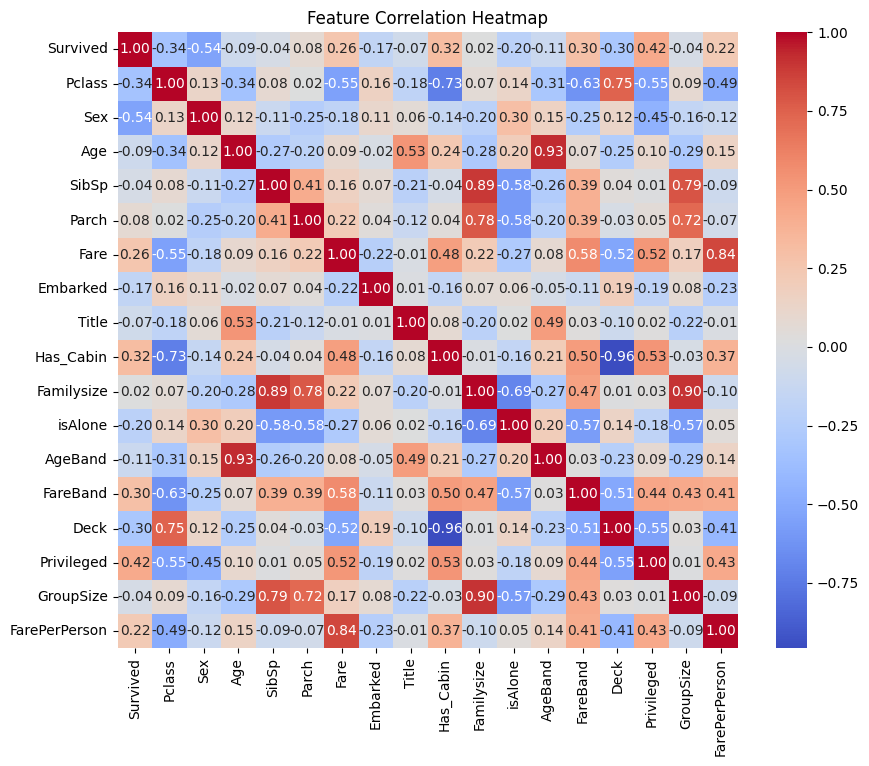

In [39]:
# 숫자형 변수만 선택하여 상관관계 분석
plt.figure(figsize=(10, 8))
numeric_features = train.select_dtypes(include=['int64', 'float64'])  # 또는 필요한 변수만 선택
corr_matrix = numeric_features.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


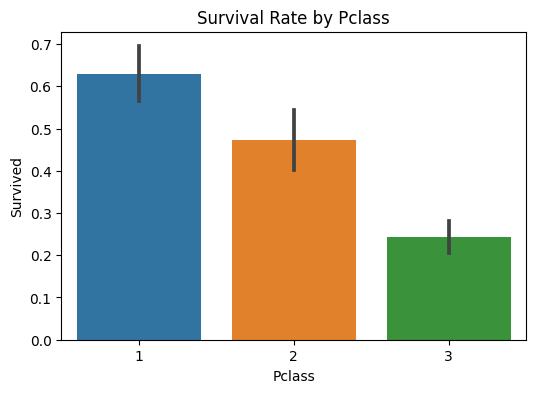

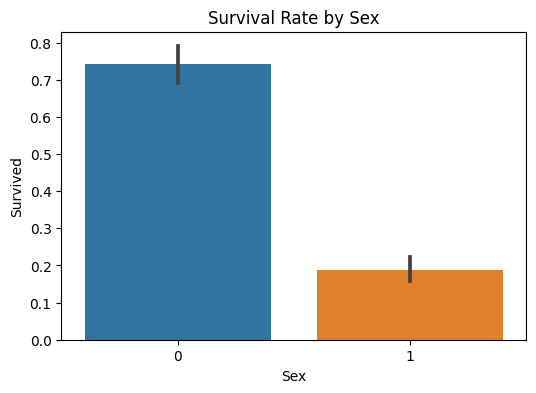

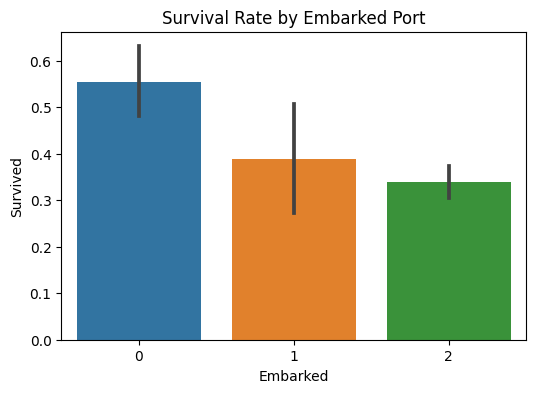

In [40]:
# Pclass vs Survived
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Pclass')
plt.show()

# Sex vs Survived
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Sex')
plt.show()

# Embarked vs Survived
plt.figure(figsize=(6, 4))
sns.barplot(x='Embarked', y='Survived', data=train)
plt.title('Survival Rate by Embarked Port')
plt.show()


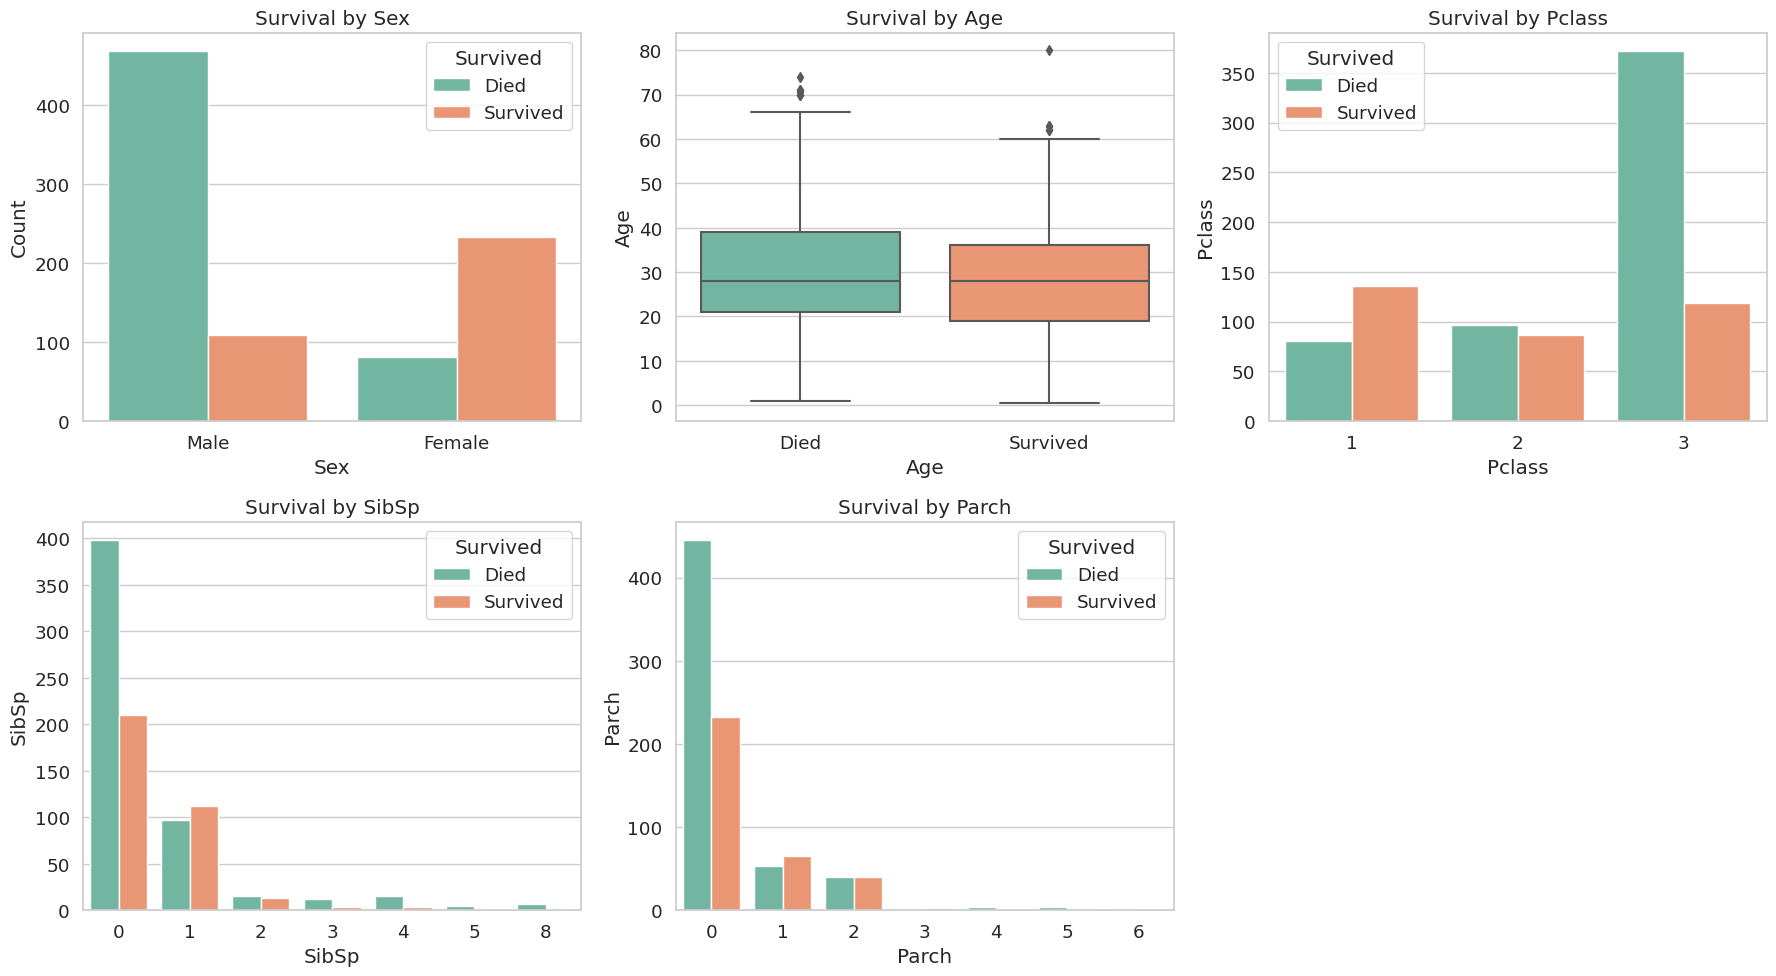

In [52]:
# 필수 라이브러리
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 예: train.csv 로딩
train = pd.read_csv('/kaggle/input/titanic/train.csv')

# 범주형 변수 매핑
train['Survived'] = train['Survived'].map({0: 'Died', 1: 'Survived'})
train['Sex'] = train['Sex'].map({'male': 'Male', 'female': 'Female'})  # 문자열이라면 그대로 사용
# 분석할 주요 변수
features = ['Sex', 'Age', 'Pclass', 'SibSp', 'Parch']
# 그래프 스타일 설정
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(18, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    if train[feature].dtype == 'object' or train[feature].nunique() < 10:
        # 범주형 변수
        sns.countplot(data=train, x=feature, hue='Survived', palette='Set2')
    else:
        # 연속형 변수는 분포를 boxplot으로
        sns.boxplot(data=train, x='Survived', y=feature, palette='Set2')

    plt.title(f"Survival by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count" if train[feature].dtype == 'object' else feature)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

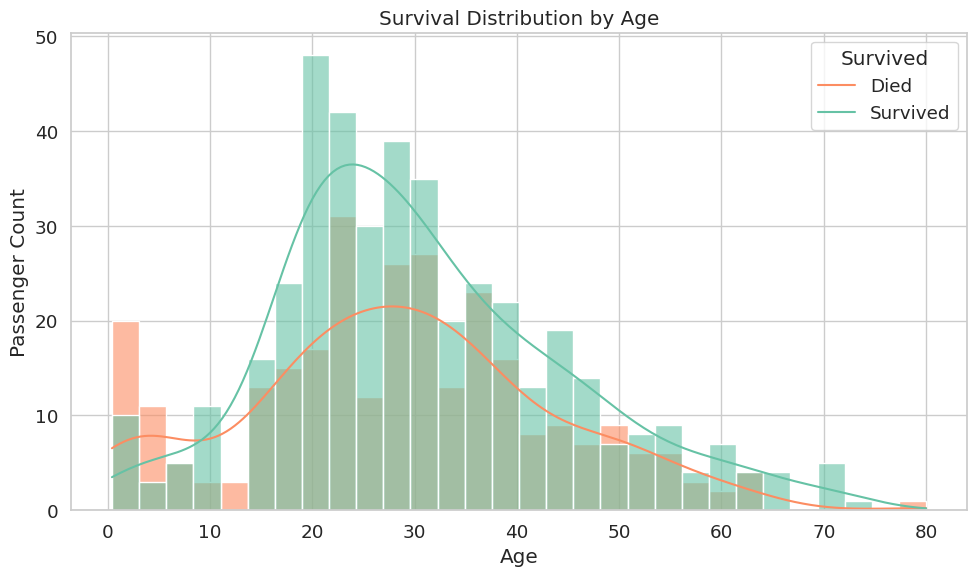

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

# 생존 여부에 따른 Age 분포 그리기
sns.histplot(data=train, x='Age', hue='Survived',
             bins=30, kde=True, palette='Set2', alpha=0.6)

plt.title("Survival Distribution by Age")
plt.xlabel("Age")
plt.ylabel("Passenger Count")
plt.legend(title="Survived", labels=["Died", "Survived"])
plt.tight_layout()
plt.show()


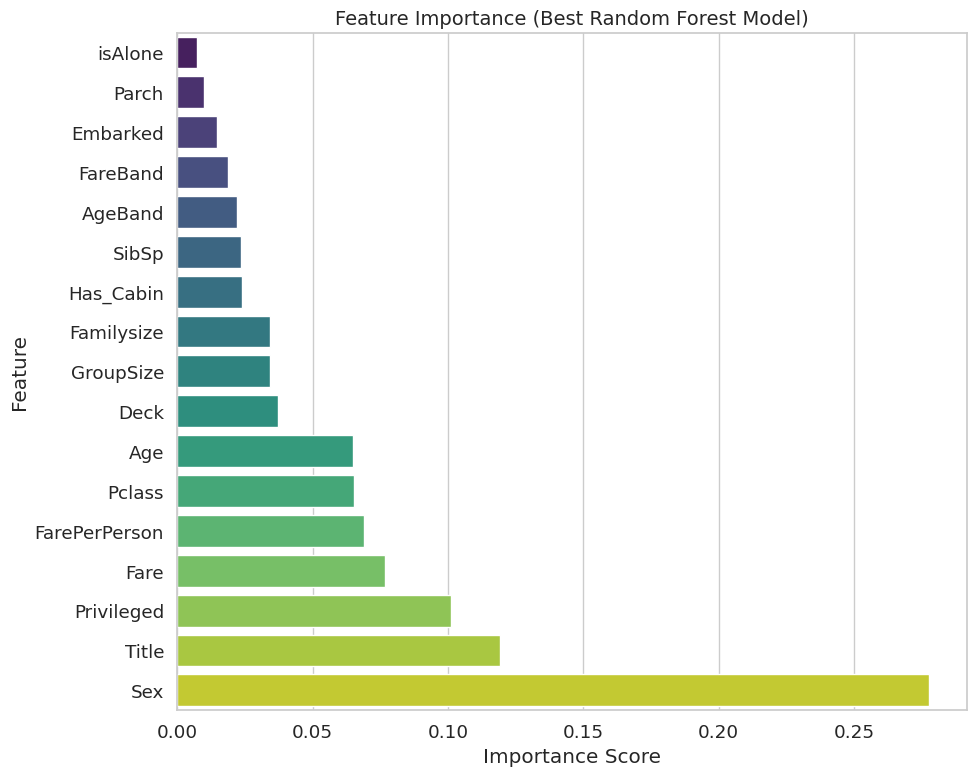

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 모델 학습 (이미 학습된 경우 생략 가능)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=4,
    max_features='sqrt',
    random_state=42
)
model.fit(train_x, train_y)

# 중요도 추출
importances = model.feature_importances_
features = train_x.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Best Random Forest Model)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
